# Analysis

# VWAP tells you “where price really traded.”
# Sentiment tells you “what investors were reading” and "how they would react"
**Objective:**  
Assess whether daily news-sentiment (“score”) can predict next-day intraday price behavior (VWAP returns) for large-cap stocks.  

## 1. Data Loading & Overview

Load the data, show its shape, and peek at the first few rows.

In [578]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime, timedelta
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')


# access drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Sentimental/'
records_path = os.path.join(path, 'data', 'records.csv')

# get stock list
stocks = pd.read_csv(os.path.join(path, 'data', 'stock_list.csv'), index_col = 0)
stock_lst = [[company, stocks.loc[company, 'stock_code']] for company in stocks.index]
stocks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,stock_code
apple,AAPL
tesla,TSLA
nvidia,NVDA


Load Data

In [579]:
records_path = os.path.join(path, 'data', 'records.csv')
df = pd.read_csv(records_path,na_values=['null_val'])
df.head()

date company stock                   datetime  \
0  20250422   apple  AAPL  2025-04-22 12:42:20+00:00   
1  20250422   apple  AAPL  2025-04-22 10:42:04+00:00   
2  20250422   apple  AAPL  2025-04-22 10:02:00+00:00   
3  20250422   apple  AAPL  2025-04-22 09:44:36+00:00   
4  20250422   apple  AAPL  2025-04-22 08:37:51+00:00   

                                                                                           title  \
0                                              Survey Shows Pent-Up Demand For New Apple iPhones   
1                             Apple Intelligence Gains Momentum as Users Show Willingness to Pay   
2                                     Sell Apple stock before it sinks another 30%, analyst says   
3  Apple (AAPL) Target Slashed to $141: ‘No Easy Answers’ as Trade Tensions and AI Lag Take Toll   
4      Cloud AI Update - Tonita Unveils AI Shopping Assistant Transforming E-Commerce Experience   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

# 2. Data Cleaning & EDA

### 2.1 Cleaning

1. Drop weekends/holidays (rows where VWAP or score is null).  
2. Deduplicate repeated news content.

In [580]:
# Count of missing values in each column
df.isnull().sum()

,0
date,0
company,0
stock,0
datetime,0
title,0
news,0
link,0
open,356
high,356
low,356


In [581]:
# since weekend do not have trade record and any other value
# we just drop it and focused on the trade day
# also drop holiday
df = df.dropna()

In [582]:
# Divide them into its own stock groups
aapl = df[df['company'] == 'apple']
tsla = df[df['company'] == 'tesla']
nvda = df[df['company'] == 'nvidia']

In [583]:
# Check duplicates because news api sometimes will have duplicates
ct_al = aapl['news'].duplicated().sum()
ct_ta = tsla['news'].duplicated().sum()
ct_na = nvda['news'].duplicated().sum()
print(ct_al,ct_ta,ct_na)

6 11 9


In [584]:
# Clean the duplicates and keep the first occurrence
aapl = aapl.drop_duplicates(subset=['news'], keep='first')
tsla = tsla.drop_duplicates(subset=['news'], keep='first')
nvda = nvda.drop_duplicates(subset=['news'], keep='first')
ct_al = aapl['news'].duplicated().sum()
ct_ta = tsla['news'].duplicated().sum()
ct_na = nvda['news'].duplicated().sum()
print(ct_al,ct_ta,ct_na)

0 0 0


### 2.2 Exploratory Data Analysis

Check distributions and basic stats for each ticker.


In [585]:
aapl = aapl.sort_values(by='date', ascending=True)
tsla = tsla.sort_values(by='date', ascending=True)
nvda = nvda.sort_values(by='date', ascending=True)
df = pd.concat([aapl, tsla,nvda], axis=0)
df[df['score'] == 100]

date company stock                   datetime  \
2492  20250423   apple  AAPL  2025-04-23 04:00:00+00:00   

                                                                    title  \
2492  Prediction: 2 AI Stocks Will Be Worth More Than Apple Stock in 2026   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [586]:
df.loc[2492, 'score'] = 3


APPLE stats:


,score,vwap
count,742.000000,742.000000
mean,-0.082210,202.762438
std,3.343571,13.590918
min,-5.000000,179.073800
25%,-3.000000,192.076700
50%,-2.000000,204.195900
75%,3.000000,214.388800
max,5.000000,223.372900


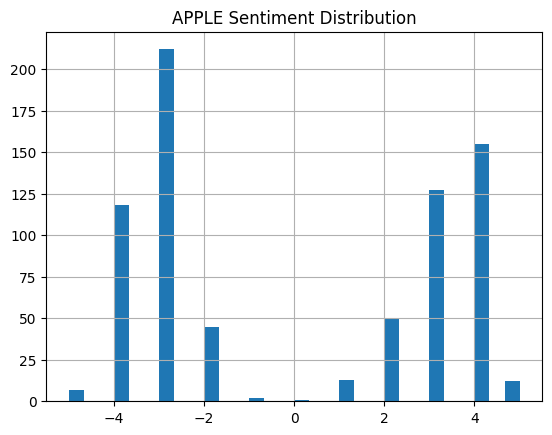


TESLA stats:


,score,vwap
count,800.000000,800.000000
mean,-0.941250,253.895495
std,3.118085,15.392731
min,-5.000000,226.144200
25%,-3.000000,243.574700
50%,-3.000000,252.717750
75%,3.000000,268.133600
max,5.000000,279.771100


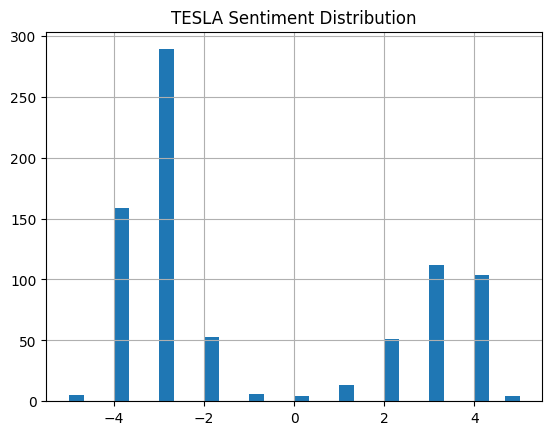


NVIDIA stats:


,score,vwap
count,748.000000,748.000000
mean,0.514706,104.142216
std,3.380557,5.032307
min,-5.000000,94.899500
25%,-3.000000,100.825400
50%,2.000000,103.827800
75%,4.000000,107.650600
max,5.000000,111.697100


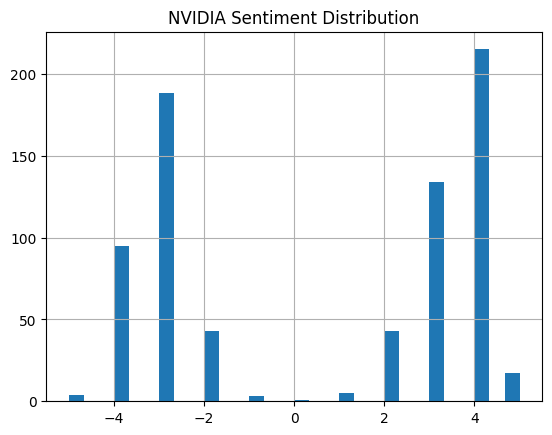

In [587]:
for ticker in ['apple','tesla','nvidia']:
    sub = df[df.company==ticker]
    print(f"\n{ticker.upper()} stats:")
    display(sub[['score','vwap']].describe())

    # Histogram of sentiment
    sub['score'].hist(bins=30)
    plt.title(f"{ticker.upper()} Sentiment Distribution")
    plt.show()

In [588]:
# Define plot func
def plot_score_vwap(data,stock):
    data = data.reset_index(drop = True)
    data = data.groupby('date')[['score','vwap']] .mean().reset_index()
    data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')
    data['date'] = data['date'].dt.strftime('%m-%d')

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the first set of data with the first y-axis
    ax1.plot(data['date'], data['score'], color='blue', marker='o', label='score')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for the second set of data
    ax2 = ax1.twinx()
    ax2.plot(data['date'], data['vwap'], color='red', marker='x', label='vwap')
    ax2.set_ylabel('vwap', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    #title and adjust the layout
    plt.title('{stock} score vs vwap'.format(stock=stock))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    fig.tight_layout()

    # Show plot
    plt.show()

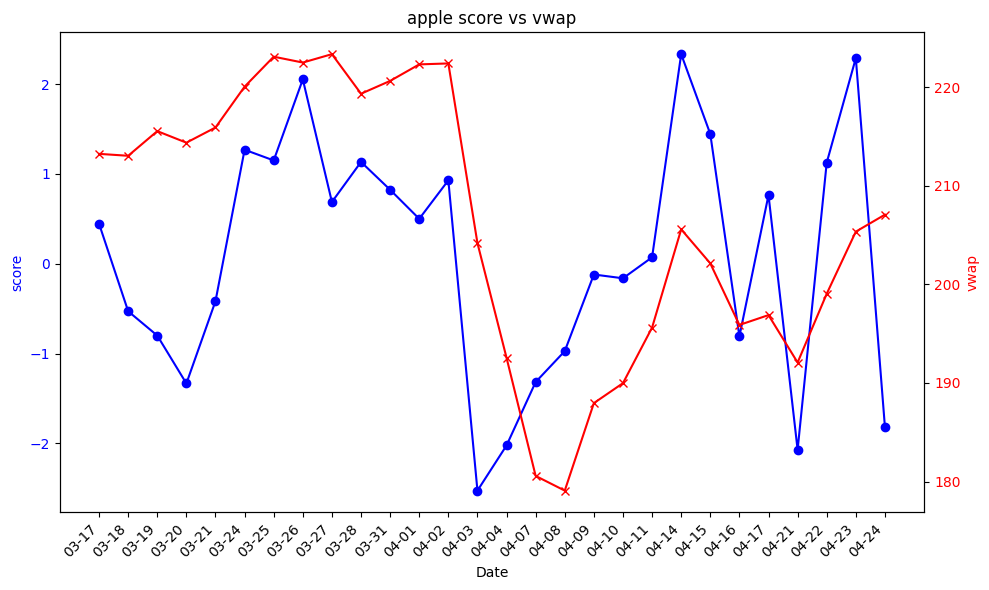

In [589]:
plot_score_vwap(aapl,'apple')

In [590]:
spearman_rho = aapl['vwap'].corr(aapl['score'], method='spearman')
print(f"Overall Spearman ρ = {spearman_rho:.3f}")
r, p = pearsonr(aapl['vwap'], aapl['score'])
print(f"Pearson r={r:.3f}, p-value={p:.3e}")

Overall Spearman ρ = 0.203
Pearson r=0.129, p-value=4.423e-04


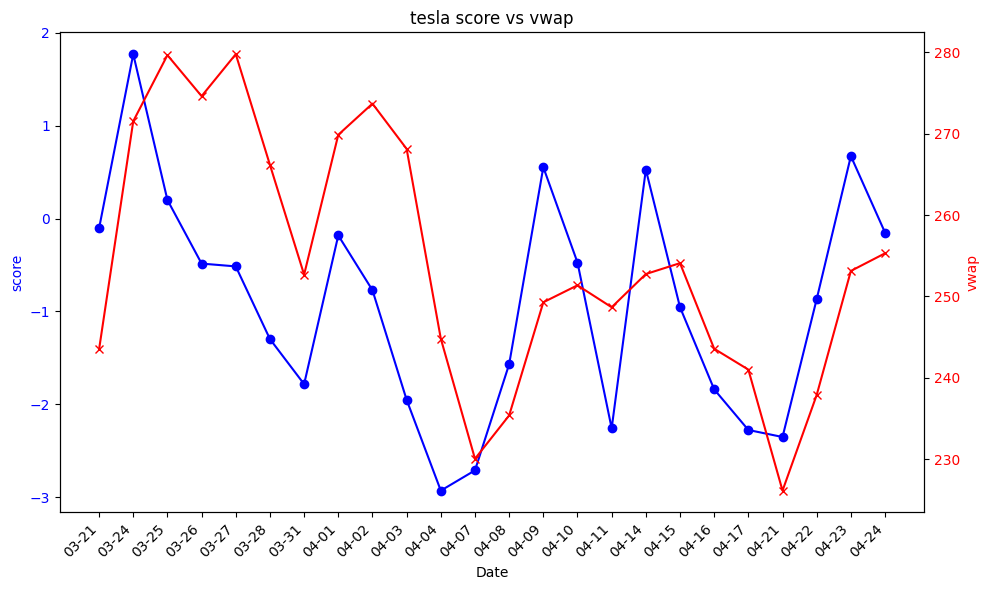

In [591]:
plot_score_vwap(tsla,'tesla')

In [592]:
spearman_rho = tsla['vwap'].corr(tsla['score'], method='spearman')
print(f"Overall Spearman ρ = {spearman_rho:.3f}")
r, p = pearsonr(tsla['vwap'], tsla['score'])
print(f"Pearson r={r:.3f}, p-value={p:.3e}")

Overall Spearman ρ = 0.208
Pearson r=0.191, p-value=4.967e-08


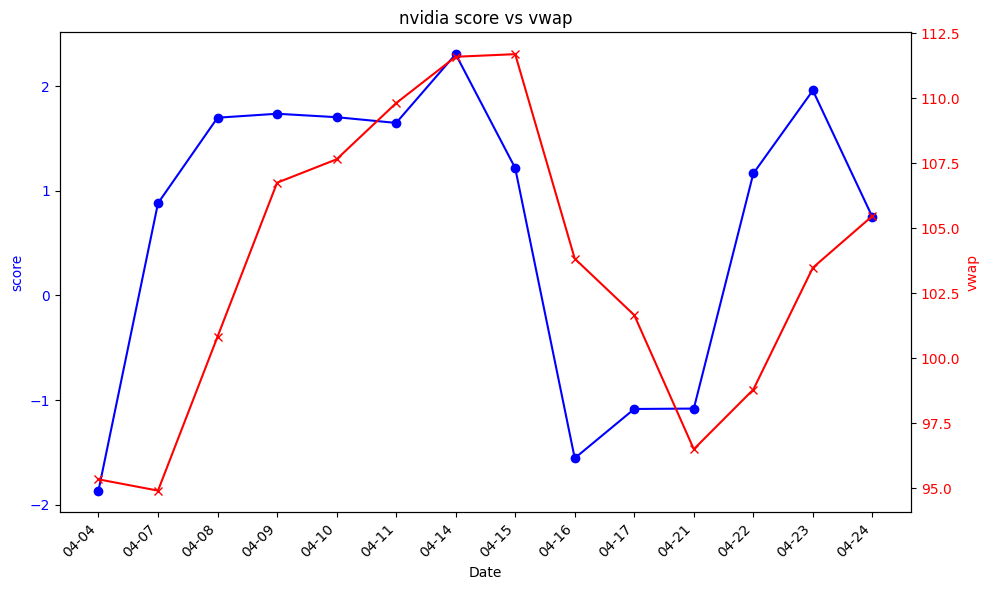

In [593]:
plot_score_vwap(nvda,'nvidia')

In [594]:
spearman_rho = nvda['vwap'].corr(nvda['score'], method='spearman')
print(f"Overall Spearman ρ = {spearman_rho:.3f}")
r, p = pearsonr(nvda['vwap'], nvda['score'])
print(f"Pearson r={r:.3f}, p-value={p:.3e}")

Overall Spearman ρ = 0.213
Pearson r=0.221, p-value=9.581e-10


# 3. Feature Engineering

1. Compute next-day VWAP return  
2. Aggregate to daily means  
3. Create sentiment buckets (low / mid / high)


## Use today's sentimental score to estimate the next day's VWAP

In [595]:
def t_plus_one_pre(df):
  df = df.reset_index(drop = True)
  df = df.groupby('date')[['score','vwap']] .mean().reset_index()
  df['t_score'] = df['score']
  df['t+1_vwap'] = df['vwap'].pct_change().shift(-1)
  df = df.dropna()

  print(df['t_score'].corr(df['t+1_vwap'], method='spearman'))

In [596]:
t_plus_one_pre(aapl)
t_plus_one_pre(tsla)
t_plus_one_pre(nvda)

-0.09462759462759461
0.17391304347826086
0.2087912087912088


Since our data source is not comprehensive, using today's sentilmental to predict the next days' vwap is not accurate.there could be some situations that the sentimental score is not accurately showing that change. Mid‑range sentiment scores (e.g. between –3 and –2) often represent ambiguous or minor news that doesn’t move the market.

## Optimizing Sentiment Thresholds to Filter Noise


In [597]:
def sentiment_threshold(df):
  df = df.reset_index(drop = True)
  df = df.groupby('date')[['score','vwap']] .mean().reset_index()
  q1, q3 = df['score'].quantile([0.25, 0.75])
  df['signal_flag'] = pd.cut(df['score'],
                           bins=[-np.inf, q1, q3, np.inf],
                           labels=['low','mid','high'])
  df['t_score'] = df['score']
  df['t+1_vwap'] = df['vwap'].pct_change().shift(-1)
  df = df.dropna()
  return df[['date','t_score','t+1_vwap','signal_flag']]


In [598]:
aapl_signals = sentiment_threshold(aapl)
tsla_signals = sentiment_threshold(tsla)
nvda_signals = sentiment_threshold(nvda)
aapl_signals

,date,t_score,t+1_vwap,signal_flag
0,20250317,0.444444,-0.000915,mid
1,20250318,-0.529412,0.011741,mid
2,20250319,-0.800000,-0.005433,mid
3,20250320,-1.333333,0.007185,low
4,20250321,-0.416667,0.019192,mid
5,20250324,1.269231,0.013823,high
6,20250325,1.150000,-0.002668,high
7,20250326,2.052632,0.003832,high
8,20250327,0.687500,-0.017975,mid
9,20250328,1.133333,0.005923,high


In [599]:
aapl_signals.groupby('signal_flag')['t+1_vwap'] \
            .agg(['count','mean','std']) \
            .reset_index()

,signal_flag,count,mean,std
0,low,6,-0.005737,0.046539
1,mid,14,0.002603,0.031337
2,high,7,-0.002631,0.015853


In [600]:
tsla_signals.groupby('signal_flag')['t+1_vwap'] \
            .agg(['count','mean','std']) \
            .reset_index()

,signal_flag,count,mean,std
0,low,6,-0.019568,0.056945
1,mid,11,0.003804,0.044603
2,high,6,0.024871,0.046754


In [601]:
nvda_signals.groupby('signal_flag')['t+1_vwap'] \
            .agg(['count','mean','std']) \
            .reset_index()

,signal_flag,count,mean,std
0,low,4,-0.013113,0.031162
1,mid,5,0.022892,0.055254
2,high,4,0.012164,0.009191


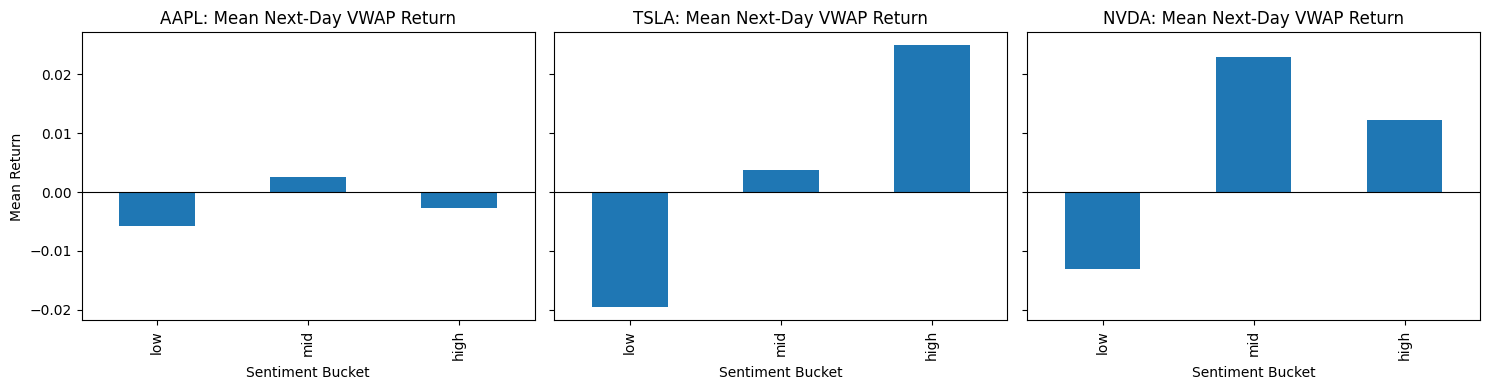

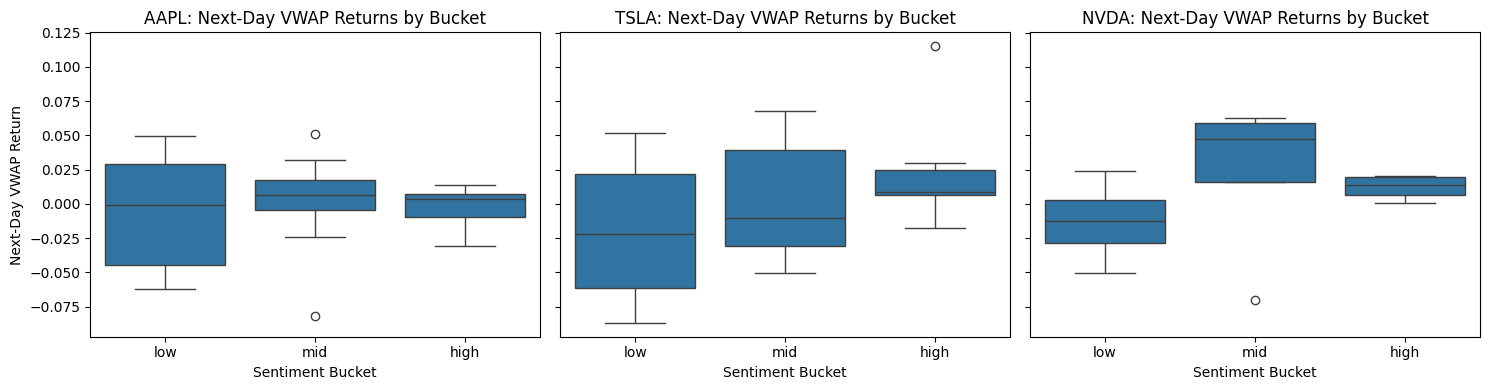

In [602]:
# Bar chart
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure you’ve defined this earlier:
signals = {
    'AAPL': aapl_signals,
    'TSLA': tsla_signals,
    'NVDA': nvda_signals
}

# Bar chart of mean next-day returns by bucket
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, (ticker, df_sig) in zip(axes, signals.items()):
    means = (
        df_sig
        .groupby('signal_flag')['t+1_vwap']
        .mean()
        .reindex(['low', 'mid', 'high'])
    )
    means.plot(kind='bar', ax=ax)
    ax.set_title(f'{ticker}: Mean Next-Day VWAP Return')
    ax.set_xlabel('Sentiment Bucket')
    ax.set_ylabel('Mean Return')
    ax.axhline(0, color='k', linewidth=0.8)

plt.tight_layout()
plt.show()

# Boxplots of next-day returns by bucket
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, (ticker, df_sig) in zip(axes, signals.items()):
    sns.boxplot(x='signal_flag', y='t+1_vwap', data=df_sig, ax=ax)
    ax.set_title(f'{ticker}: Next-Day VWAP Returns by Bucket')
    ax.set_xlabel('Sentiment Bucket')
    ax.set_ylabel('Next-Day VWAP Return')

plt.tight_layout()
plt.show()


# 4. Statistical Tests & Effect Sizes

1.Compare “high” vs “low” buckets with both:
- t-test  
- Mann–Whitney
2.Compare “high10%” vs “low10%” buckets with both:
- t-test  
- Mann–Whitney


## Plot Distribution

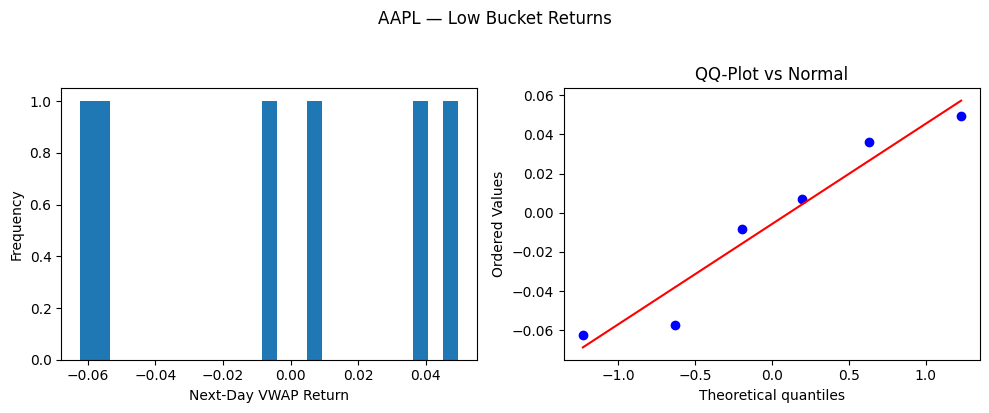

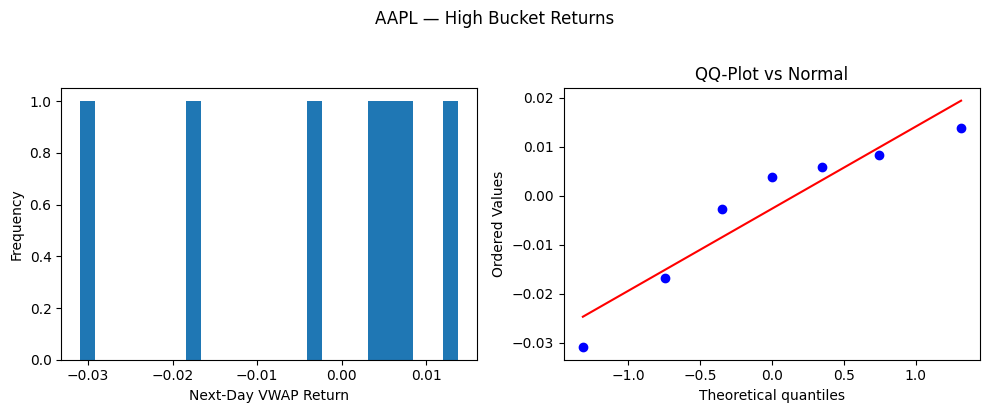

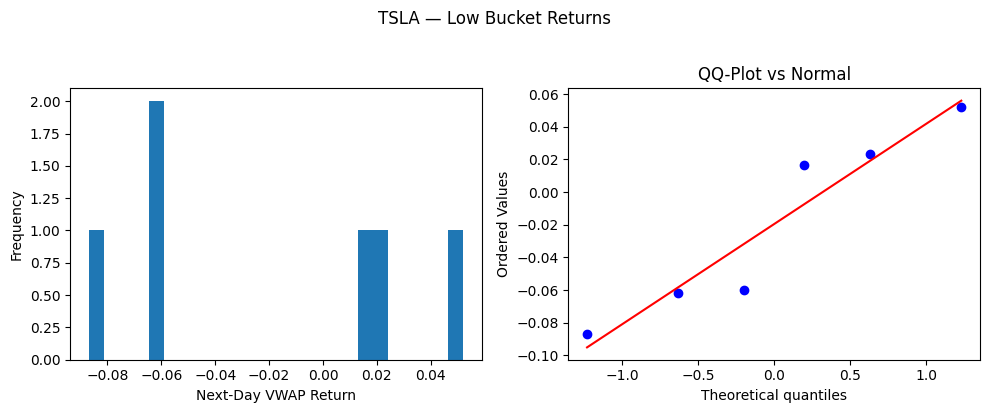

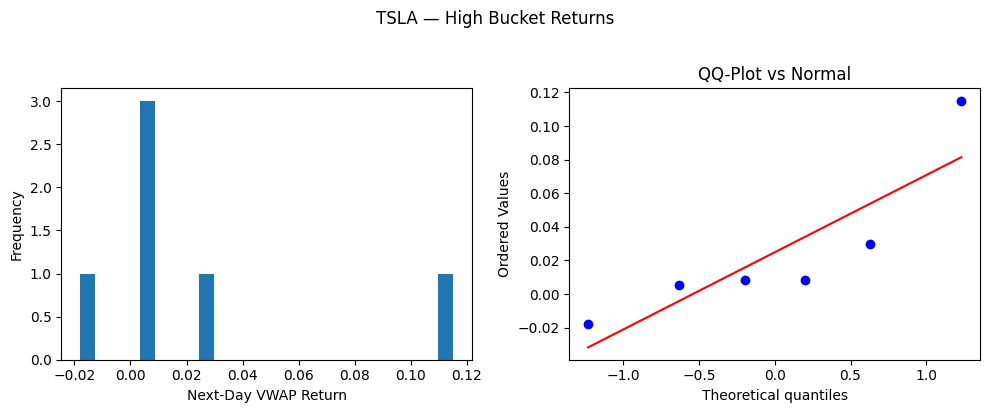

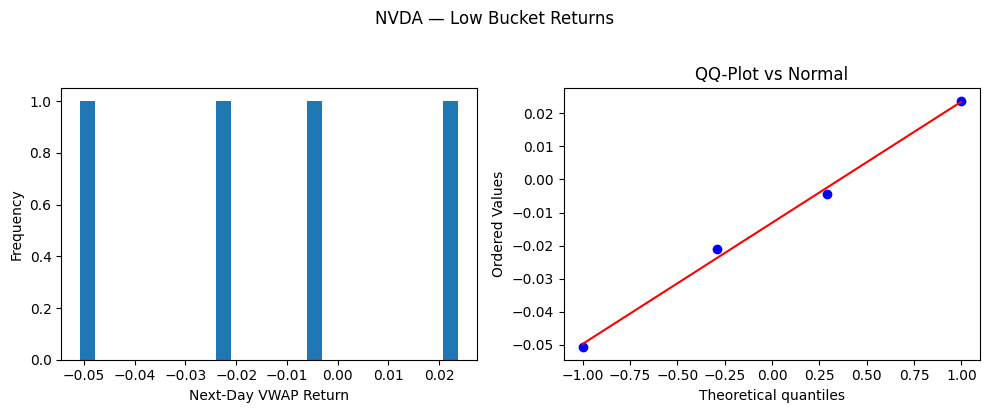

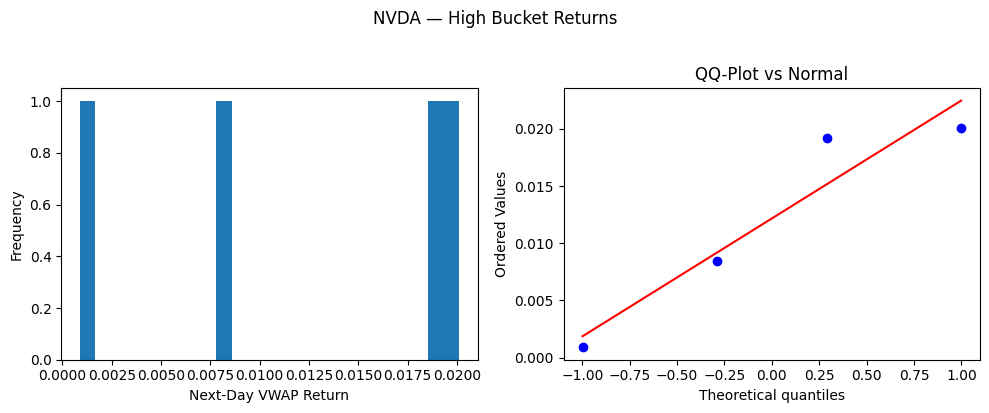

In [603]:
for ticker, signals in [
    ('AAPL', aapl_signals),
    ('TSLA', tsla_signals),
    ('NVDA', nvda_signals)
]:
    for bucket in ['low', 'high']:
        data = signals.loc[signals['signal_flag'] == bucket, 't+1_vwap'].dropna()

        fig, (ax_hist, ax_qq) = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(f"{ticker} — {bucket.capitalize()} Bucket Returns", y=1.02)

        # Histogram
        ax_hist.hist(data, bins=25)
        ax_hist.set_xlabel('Next-Day VWAP Return')
        ax_hist.set_ylabel('Frequency')

        # QQ-plot
        stats.probplot(data, dist="norm", plot=ax_qq)
        ax_qq.set_title('QQ-Plot vs Normal')

        plt.tight_layout()
        plt.show()


## Sentiment Buckets Analysis

We’ll test whether days flagged as **high** sentiment produce significantly different next-day VWAP returns than days flagged **low**, for AAPL, TSLA, and NVDA. We’ll then summarize the t-statistic, p-value, and mean returns side-by-side, and visualize the average next-day return per bucket.


In [604]:
results = []
for name, df_sig in [('AAPL', aapl_signals),
                     ('TSLA', tsla_signals),
                     ('NVDA', nvda_signals)]:
    # Select high vs low
    high = df_sig.loc[df_sig['signal_flag']=='high', 't+1_vwap']
    low  = df_sig.loc[df_sig['signal_flag']=='low',  't+1_vwap']

    # Run independent t-test (unequal variances)
    t_stat, p_val = ttest_ind(high, low, equal_var=False, nan_policy='omit')

    # Compute bucket means
    mean_high = high.mean()
    mean_low  = low.mean()

    results.append({
        'Ticker': name,
        'Mean Return (High)': mean_high,
        'Mean Return (Low)': mean_low,
        'Δ Mean': mean_high - mean_low,
        'T-statistic': t_stat,
        'p-value': p_val
    })

# Create a summary DataFrame
ttest_summary = pd.DataFrame(results)
ttest_summary


,Ticker,Mean Return (High),Mean Return (Low),Δ Mean,T-statistic,p-value
0,AAPL,-0.002631,-0.005737,0.003107,0.155949,0.881192
1,TSLA,0.024871,-0.019568,0.044439,1.477380,0.171499
2,NVDA,0.012164,-0.013113,0.025277,1.556051,0.204217


From the table above, we can see for each ticker:
- **Mean Return (High)** vs **Mean Return (Low)**
- The difference in means (Δ Mean)
- The t-statistic and its p-value

A p-value < 0.05 indicates that next-day VWAP returns on high-sentiment days are statistically significantly different from low-sentiment days.


**Interpretation:**  
we fail to reject the null hypothesis for each ticker.

## Mann–Whitney

In [605]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming you’ve already built these DataFrames:
# aapl_signals, tsla_signals, nvda_signals
# each with columns ['t+1_vwap', 'signal_flag'] where signal_flag ∈ {'low','mid','high'}

mw_results = []
for name, df_sig in [('AAPL', aapl_signals),
                     ('TSLA', tsla_signals),
                     ('NVDA', nvda_signals)]:
    # Extract high vs low samples
    high = df_sig.loc[df_sig['signal_flag']=='high', 't+1_vwap']
    low  = df_sig.loc[df_sig['signal_flag']=='low',  't+1_vwap']

    # Run Mann–Whitney U (two-sided by default)
    u_stat, p_val = mannwhitneyu(high, low, alternative='two-sided')

    # Record medians for context
    med_high = high.median()
    med_low  = low.median()

    mw_results.append({
        'Ticker': name,
        'Median Return (High)': med_high,
        'Median Return (Low)':  med_low,
        'U-statistic': u_stat,
        'p-value':      p_val
    })

mw_summary = pd.DataFrame(mw_results)
print(mw_summary)

  Ticker  Median Return (High)  Median Return (Low)  U-statistic   p-value
0   AAPL              0.003832            -0.000536         21.0  1.000000
1   TSLA              0.008467            -0.021947         23.0  0.484848
2   NVDA              0.013836            -0.012745         12.0  0.342857


## Stricter Sentiment Thresholds

Instead of quartiles, use deciles or even the top & bottom 10%.

In [606]:
def extreme_threshold(df):
    # 1) Aggregate to daily
    df = df.reset_index(drop=True)
    df = df.groupby('date')[['score','vwap']].mean().reset_index()

    # 2) Compute today’s score & next‐day return
    df['t_score']  = df['score']
    df['t+1_vwap'] = df['vwap'].pct_change().shift(-1)

    # 3) Define your quantiles
    q_low  = df['score'].quantile(0.10)
    q_high = df['score'].quantile(0.90)

    # 4) Cut into low / mid / high
    df['signal_flag_extreme'] = pd.cut(
        df['score'],
        bins=[-np.inf, q_low, q_high, np.inf],
        labels=['low10%', 'mid80%', 'high10%']
    )

    # 5) Drop anything that isn’t extreme
    df = df[df['signal_flag_extreme'].isin(['low10%','high10%'])]

    # 6) Drop NaNs from that last shift
    df = df.dropna(subset=['t+1_vwap'])

    return df[['date','t_score','t+1_vwap','signal_flag_extreme']]


In [607]:
aapl_signals = extreme_threshold(aapl)
tsla_signals = extreme_threshold(tsla)
nvda_signals = extreme_threshold(nvda)

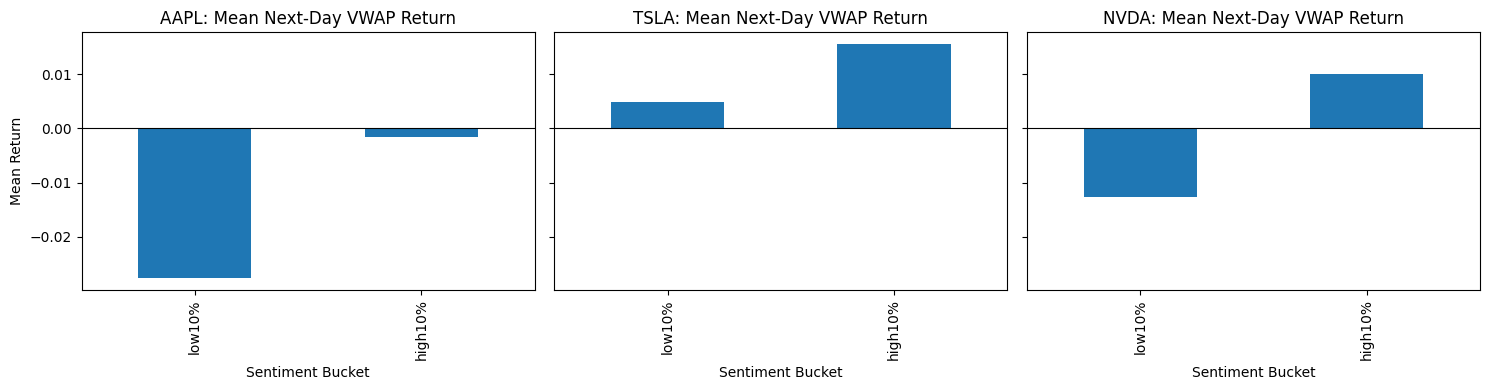

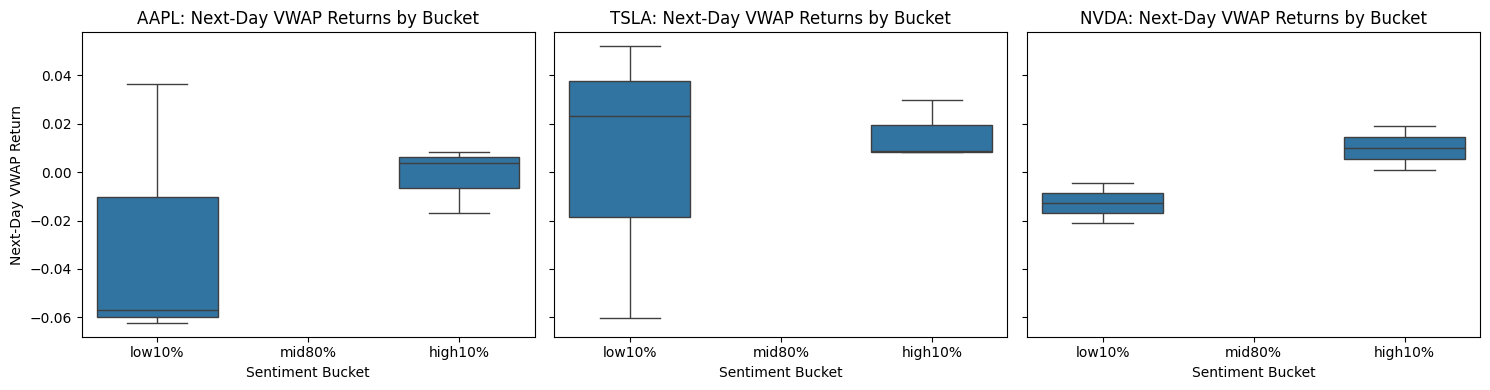

In [608]:
 #Bar chart
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure you’ve defined this earlier:
signals = {
    'AAPL': aapl_signals,
    'TSLA': tsla_signals,
    'NVDA': nvda_signals
}

# Bar chart of mean next-day returns by bucket
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, (ticker, df_sig) in zip(axes, signals.items()):
    means = (
        df_sig
        .groupby('signal_flag_extreme')['t+1_vwap']
        .mean()
        .reindex(['low10%','high10%'])
    )
    means.plot(kind='bar', ax=ax)
    ax.set_title(f'{ticker}: Mean Next-Day VWAP Return')
    ax.set_xlabel('Sentiment Bucket')
    ax.set_ylabel('Mean Return')
    ax.axhline(0, color='k', linewidth=0.8)

plt.tight_layout()
plt.show()

# Boxplots of next-day returns by bucket
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, (ticker, df_sig) in zip(axes, signals.items()):
    sns.boxplot(x='signal_flag_extreme', y='t+1_vwap', data=df_sig, ax=ax)
    ax.set_title(f'{ticker}: Next-Day VWAP Returns by Bucket')
    ax.set_xlabel('Sentiment Bucket')
    ax.set_ylabel('Next-Day VWAP Return')

plt.tight_layout()
plt.show()


In [609]:
results = []
for name, df_sig in [('AAPL', aapl_signals),
                     ('TSLA', tsla_signals),
                     ('NVDA', nvda_signals)]:
    # Select high vs low
    high = df_sig.loc[df_sig['signal_flag_extreme']=='high10%', 't+1_vwap']
    low  = df_sig.loc[df_sig['signal_flag_extreme']=='low10%',  't+1_vwap']

    # Run independent t-test (unequal variances)
    t_stat, p_val = ttest_ind(high, low, equal_var=False, nan_policy='omit')

    # Compute bucket means
    mean_high = high.mean()
    mean_low  = low.mean()

    results.append({
        'Ticker': name,
        'Mean Return (High)': mean_high,
        'Mean Return (Low)': mean_low,
        'Δ Mean': mean_high - mean_low,
        'T-statistic': t_stat,
        'p-value': p_val
    })

# Create a summary DataFrame
ttest_summary = pd.DataFrame(results)
ttest_summary

,Ticker,Mean Return (High),Mean Return (Low),Δ Mean,T-statistic,p-value
0,AAPL,-0.001524,-0.027652,0.026129,0.793072,0.503243
1,TSLA,0.015613,0.004947,0.010667,0.309921,0.783770
2,NVDA,0.010066,-0.012745,0.022812,1.855663,0.206220


**Interpretation:**  
we fail to reject the null hypothesis for each ticker.

## Mann–Whitney

In [610]:
mw_results = []
for name, df_sig in [('AAPL', aapl_signals),
                     ('TSLA', tsla_signals),
                     ('NVDA', nvda_signals)]:
    # Extract high vs low samples
    high = df_sig.loc[df_sig['signal_flag_extreme']=='high10%', 't+1_vwap']
    low  = df_sig.loc[df_sig['signal_flag_extreme']=='low10%',  't+1_vwap']

    # Run Mann–Whitney U (two-sided by default)
    u_stat, p_val = mannwhitneyu(high, low, alternative='two-sided')

    # Record medians for context
    med_high = high.median()
    med_low  = low.median()

    mw_results.append({
        'Ticker': name,
        'Median Return (High)': med_high,
        'Median Return (Low)':  med_low,
        'U-statistic': u_stat,
        'p-value':      p_val
    })

mw_summary = pd.DataFrame(mw_results)
print(mw_summary)

  Ticker  Median Return (High)  Median Return (Low)  U-statistic   p-value
0   AAPL              0.003832            -0.057011          6.0  0.700000
1   TSLA              0.008562             0.023153          4.0  1.000000
2   NVDA              0.010066            -0.012745          4.0  0.333333


# Prediction

In [611]:
def process(df):
  df = df.reset_index(drop = True)
  df = df.groupby('date')[['score','vwap']] .mean().reset_index()
  df['t_score'] = df['score']
  df['t+1_vwap'] = df['vwap'].pct_change().shift(-1)
  df = df.dropna()
  return df

In [626]:
aapl = process(aapl)
tsla = process(tsla)
nvda = process(nvda)
all_df = pd.concat([
    aapl.assign(ticker='AAPL'),
    tsla.assign(ticker='TSLA'),
    nvda.assign(ticker='NVDA')
]).reset_index(drop=True)

In [627]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1) Create the binary target
df = all_df.copy()   # replace with your actual df variable
df['target_up'] = (df['t+1_vwap'] > 0).astype(int)

# 2) Select features and target
#    You can start with today's sentiment and VWAP level:
X = df[['t_score', 'vwap']]
y = df['target_up']

# 3) Train/test split (time-ordered: no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 4) Build two simple pipelines
models = {
    'LogisticRegression': make_pipeline(StandardScaler(), LogisticRegression()),
    'RandomForest':       make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
}

# 5) Fit and evaluate on the test set
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC AUC:", roc_auc_score(y_test, y_prob).round(3))

# 6) (Optional) 5-fold cross-validated AUC on full data
for name, model in models.items():
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    print(f"{name} CV AUC: {auc:.3f}")



=== LogisticRegression ===
Confusion Matrix:
[[0 4]
 [0 8]]

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.667     1.000     0.800         8

    accuracy                          0.667        12
   macro avg      0.333     0.500     0.400        12
weighted avg      0.444     0.667     0.533        12

ROC AUC: 0.969

=== RandomForest ===
Confusion Matrix:
[[1 3]
 [1 7]]

Classification Report:
              precision    recall  f1-score   support

           0      0.500     0.250     0.333         4
           1      0.700     0.875     0.778         8

    accuracy                          0.667        12
   macro avg      0.600     0.562     0.556        12
weighted avg      0.633     0.667     0.630        12

ROC AUC: 0.516
LogisticRegression CV AUC: 0.663
RandomForest CV AUC: 0.360
